# Image Caption Generator

The aim of the project is to develop an image caption generator that can automatically generate meaningful and contextually relevant captions for a given image. Image captioning combines computer vision and natural language processing techniques. It uses the VGG16 model, a widely used convolutional neural network (CNN) to generate descriptive captions.

## Import Libraries

In [86]:
import os
import pickle
import numpy as np
import pandas as pd
from tqdm.notebook import tqdm
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Model
from tensorflow.keras.utils import to_categorical, plot_model
from tensorflow.keras.layers import Input, Dense, LSTM, Embedding, Dropout, add
from keras.applications.vgg16 import VGG16
from PIL import Image
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
from nltk.translate.bleu_score import corpus_bleu

In [87]:
directory1 = "Flicker8k_text/Flickr8k.token.txt"
directory2 = "Flicker8k_Dataset"

## Explore Data

The project uses the Flickr 8k dataset. It consists of 8000 images that are each paired with five different captions which provide clear descriptions of the salient entities and events. The images were chosen from six different Flickr groups, and tend not to contain any well-known people or locations, but were manually selected to depict a variety of scenes and situations


Dataset link: https://www.kaggle.com/datasets/ming666/flicker8k-dataset

In [88]:
df = pd.read_csv(directory1, sep="\t", header = None)
df

,0,1
0,1000268201_693b08cb0e.jpg#0,A child in a pink dress is climbing up a set o...
1,1000268201_693b08cb0e.jpg#1,A girl going into a wooden building .
2,1000268201_693b08cb0e.jpg#2,A little girl climbing into a wooden playhouse .
3,1000268201_693b08cb0e.jpg#3,A little girl climbing the stairs to her playh...
4,1000268201_693b08cb0e.jpg#4,A little girl in a pink dress going into a woo...
...,...,...
40455,997722733_0cb5439472.jpg#0,A man in a pink shirt climbs a rock face
40456,997722733_0cb5439472.jpg#1,A man is rock climbing high in the air .
40457,997722733_0cb5439472.jpg#2,A person in a red shirt climbing up a rock fac...
40458,997722733_0cb5439472.jpg#3,A rock climber in a red shirt .


 Visualization of data using the PIL (Python Imaging Library) library.

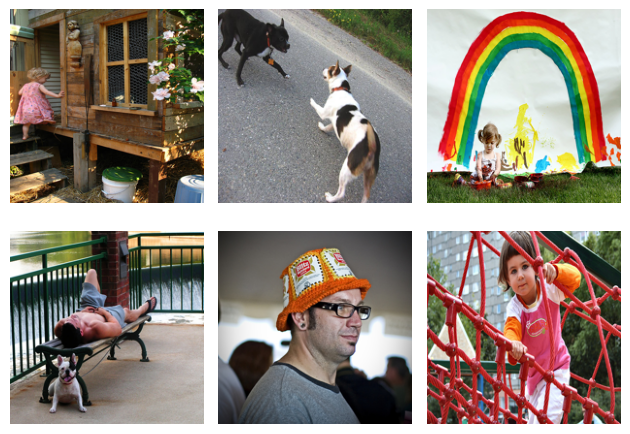

In [89]:
image_files = os.listdir(directory2)
image_size = (200, 200) 

fig, axes = plt.subplots(2, 3)

for i, ax in enumerate(axes.flat):
    if i < len(image_files):
        image_path = os.path.join(directory2, image_files[i])
        image = Image.open(image_path)
        image = image.resize(image_size)
        ax.imshow(image)
        ax.axis('off')
    else:
        ax.axis('off')

plt.tight_layout()
plt.show()

### Data Preprocessing

The VGG16 model was trained on the ImageNet dataset, which is a large-scale image classification competition. In this competition, the images were preprocessed and resized to a fixed size of (224, 224) pixels before being used to train the model.

Load the VGG16 model.

In [90]:
model = VGG16()
model = Model(inputs=model.inputs, outputs=model.layers[-2].output)
print(model.summary())

Model: "model_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_18 (InputLayer)       [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0  

From visualizations, we can see that all images are not of the same size. We resize it to (224, 224) pixels as the model requires this input size for the image. This pre-trained model is used to extract the features. We create an empty dictionary called features to store the extracted features.

We use tqdm for progress bar visualization.

In [18]:
features = {}
for img in tqdm(os.listdir(directory2)):
    img1 = os.path.join(directory2, img)
    image = load_img(img1, target_size=(224, 224))
    image = img_to_array(image)
    image = image.reshape((1, image.shape[0], image.shape[1], image.shape[2])) #for model
    image = preprocess_input(image)
    feature = model.predict(image, verbose=0)
    image_id = img.split(".")[0]
    features[image_id] = feature

  0%|          | 0/8091 [00:00<?, ?it/s]

Storing features in a pickle file.


In [20]:
pickle.dump(features, open("features.pkl","wb"))

In [91]:
with open('features.pkl', 'rb') as f:
    features = pickle.load(f)

In [92]:
with open(directory1, 'r') as f:
    captions = f.read()

Preprocess Text Data

We create a dictionary called mapping to store the image ID and caption associations.

In [93]:
mapping = {}
for line in tqdm(captions.split("\n")):
    tokens = line.split("\t")
    if len(line)<2:
        continue 
    image_id, caption = tokens[0], tokens[1:]
    image_id = image_id.split(".")[0]
    caption = " ".join(caption)
    if image_id not in mapping:
        mapping[image_id] = []
    mapping[image_id].append(caption)

  0%|          | 0/40461 [00:00<?, ?it/s]

In [94]:
mapping.pop("2258277193_586949ec62")

['people waiting for the subway',
 'Some people looking out windows in a large building .',
 'Three people are waiting on a train platform .',
 'Three people standing at a station .',
 'two woman and one man standing near train tracks .']

We remove symbols, special characters, non-alphanumeric characters, extra spaces etc. from each caption as they do not typically contribute much to the meaning or understanding of a caption.

In [95]:
def clean(mapping):
    for img, captions in mapping.items():
        for i in range(len(captions)):
            caption = captions[i]
            caption = caption.lower()
            caption = caption.replace("[*A-Za-z]", "")
            caption = caption.replace("\s+", " ")
            caption = 'startseq ' + ' '.join([word for word in caption.split() if len(word)>1]) +' endseq'
            captions[i]=caption

In [96]:
clean(mapping)

Storing all captions in a list.


In [97]:
all_captions = [] 
for img in mapping:
    for caption in mapping[img]:
        all_captions.append(caption)

In [98]:
all_captions[:10]

['startseq child in pink dress is climbing up set of stairs in an entry way endseq',
 'startseq girl going into wooden building endseq',
 'startseq little girl climbing into wooden playhouse endseq',
 'startseq little girl climbing the stairs to her playhouse endseq',
 'startseq little girl in pink dress going into wooden cabin endseq',
 'startseq black dog and spotted dog are fighting endseq',
 'startseq black dog and tri-colored dog playing with each other on the road endseq',
 'startseq black dog and white dog with brown spots are staring at each other in the street endseq',
 'startseq two dogs of different breeds looking at each other on the road endseq',
 'startseq two dogs on pavement moving toward each other endseq']

The Tokenizer class is has been used for converting text into a numerical representation suitable for training the model.

In [99]:
#Tokenize
tokenizer = Tokenizer()
tokenizer.fit_on_texts(all_captions)
vocab_size = len(tokenizer.word_index) + 1
print("Number of unique words:", vocab_size)

Number of unique words: 8485


In [100]:
max_length = max(len(caption.split()) for caption in all_captions)
print("Maximum length of caption:", max_length)

Maximum length of caption: 34


In [101]:
image_ids = list(mapping.keys())
train = image_ids[:7281]
test = image_ids[7281:]

The data_generator function generates batches of training data in a loop, iterating over the data keys, mapping, and features to create input-output pairs. It allows for efficient training by providing data in batches.

In [102]:
def data_generator(data_keys, mapping, features, tokenizer, max_length, vocab_size, batch_size):
    X1, X2, y = list(), list(), list()
    n = 0
    while 1:
        for key in data_keys:
            n += 1
            captions = mapping[key]
            for caption in captions:
                seq = tokenizer.texts_to_sequences([caption])[0]
                for i in range(1, len(seq)):
                    in_seq, out_seq = seq[:i], seq[i]
                    in_seq = pad_sequences([in_seq], maxlen=max_length)[0]
                    out_seq = to_categorical([out_seq], num_classes=vocab_size)[0]
                    X1.append(features[key][0])
                    X2.append(in_seq)
                    y.append(out_seq)
            if n == batch_size:
                X1, X2, y = np.array(X1), np.array(X2), np.array(y)
                yield [X1, X2], y
                X1, X2, y = list(), list(), list()
                n = 0

## Model

To build the model, we will use the TensorFlow Keras API for easy implementation. The model architecture consists of dropout layers, dense layers, an embedding layer, an LSTM layer. To help prevent overfitting, we use a dropout layer. The neural network model takes two inputs (feature vector and sequence of integers) and produces a probability distribution over the vocabulary for generating captions.

In [103]:
inputs1 = Input(shape=(4096,))
fe1 = Dropout(0.4)(inputs1)
fe2 = Dense(256, activation='relu')(fe1)
inputs2 = Input(shape=(max_length,))
se1 = Embedding(vocab_size, 256, mask_zero=True)(inputs2)
se2 = Dropout(0.4)(se1)
se3 = LSTM(256)(se2)
decoder1 = add([fe2, se3])
decoder2 = Dense(256, activation='relu')(decoder1)
outputs = Dense(vocab_size, activation='softmax')(decoder2)
model = Model(inputs=[inputs1, inputs2], outputs=outputs)
model.compile(loss='categorical_crossentropy', optimizer='adam')

Train the model

In [104]:
epochs = 30
batch_size = 32
steps = len(train) // batch_size

for i in range(epochs):
    generator = data_generator(train, mapping, features, tokenizer, max_length, vocab_size, batch_size)
    model.fit(generator, epochs=1, steps_per_epoch=steps, verbose=1)

227/227 [==============================] - 388s 2s/step - loss: 1.9595


In [109]:
model.save("model.h5")

## Generate Captions

The idx_to_word function is used to convert an integer index back to its corresponding word using the tokenizer's word-to-index mapping.

In [118]:
def idx_to_word(integer, tokenizer):
    for word, index in tokenizer.word_index.items():
        if index==integer:
            return word

The predict_caption function generates a caption for an image by iteratively predicting each word in the caption sequence. The loop terminates either when the maximum caption length is reached or when the predicted word is "endseq". The resulting caption is returned as a string.

In [120]:
def predict_caption(model, image, tokenizer, max_length):
    in_text = "startseq"
    for i in range(max_length):
        sequence = tokenizer.texts_to_sequences([in_text])[0]
        sequence = pad_sequences([sequence], max_length)
        y_pred = model.predict([image, sequence], verbose=0)
        y_pred = np.argmax(y_pred)
        word = idx_to_word(y_pred, tokenizer)
        if word is None:
            break
        in_text+= " " + word
        if word=="endseq":
            break
    return in_text

In [121]:
actual, predicted = list(), list()
for key in tqdm(test):
    captions = mapping[key]
    y_pred = predict_caption(model, features[key], tokenizer, max_length)
    actual_captions = [caption.split() for caption in captions]
    y_pred = y_pred.split()
    actual.append(actual_captions)
    predicted.append(y_pred)

  0%|          | 0/810 [00:00<?, ?it/s]

## Evaluation

We evaluate the performance of a caption generation model by calculating the BLEU scores between the actual and predicted captions for the test dataset.

In [122]:
from nltk.translate.bleu_score import corpus_bleu
actual, predicted = list(), list()

for key in tqdm(test):
    captions = mapping[key]
    y_pred = predict_caption(model, features[key], tokenizer, max_length) 
    actual_captions = [caption.split() for caption in captions]
    y_pred = y_pred.split()
    actual.append(actual_captions)
    predicted.append(y_pred)
    
# calculate BLEU score
print("BLEU-1: %f" % corpus_bleu(actual, predicted, weights=(1.0, 0, 0, 0)))
print("BLEU-2: %f" % corpus_bleu(actual, predicted, weights=(0.5, 0.5, 0, 0)))

  0%|          | 0/810 [00:00<?, ?it/s]

BLEU-1: 0.533886
BLEU-2: 0.312763


## Results 

The generate_caption function is used to visualize and compare the actual and predicted captions for a given image.

In [125]:
def generate_caption(image_name):
    image_path = os.path.join(directory2, image_name)
    image_id = image_name.split(".")[0]
    image = Image.open(image_path)
    plt.imshow(image)
    captions = mapping[image_id]
    print("Actual caption:")
    for caption in captions:
        print(caption)
    y_pred = predict_caption(model, features[image_id], tokenizer, max_length)
    print("Predicted caption:")
    print(y_pred)

Actual caption:
startseq man in an orange hat starring at something endseq
startseq man wears an orange hat and glasses endseq
startseq man with gauges and glasses is wearing blitz hat endseq
startseq man with glasses is wearing beer can crocheted hat endseq
startseq the man with pierced ears is wearing glasses and an orange hat endseq
Predicted caption:
startseq man with pierced ears wears glasses endseq


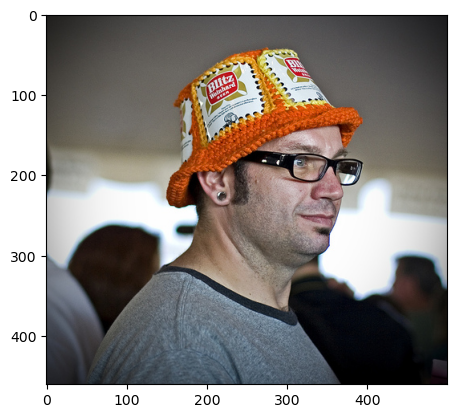

In [129]:
generate_caption("1007129816_e794419615.jpg") 

Actual caption:
startseq people sit on the mountainside and check out the view endseq
startseq three people are on hilltop overlooking green valley endseq
startseq three people hang out on top of big hill endseq
startseq three people overlook green valley endseq
startseq three people rest on ledge above the moutains endseq
Predicted caption:
startseq two people are sitting on the grassy hillside endseq


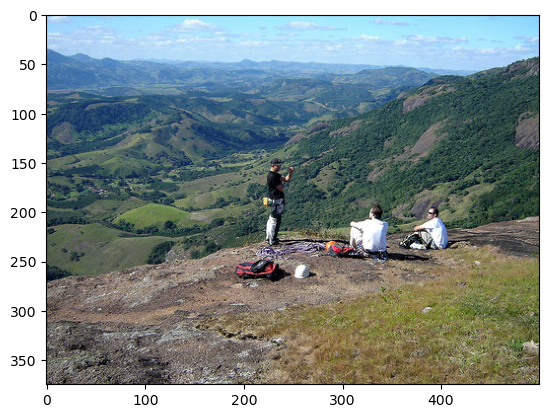

In [135]:
generate_caption("104136873_5b5d41be75.jpg")